# Alter Ego Chess Engine

The purpose of the project is to create a simple chess engine trained using Neural Networks. The benchmark for the engine is an ability to win 4 out of 5 games against my friends (~1000-1500 elo)

Dataset -> https://www.kaggle.com/datasets/mysarahmadbhat/online-chess-games

In [1]:
import numpy as np
import pandas as pd

In [3]:
data_df = pd.read_csv('./data/chess_games.csv')
data_df.tail()

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
20053,20054,True,24,Resign,White,10+10,belcolt,1691,jamboger,1220,d4 f5 e3 e6 Nf3 Nf6 Nc3 b6 Be2 Bb7 O-O Be7 Ne5...,A80,2,Dutch Defense,Dutch Defense,NaN,NaN
20054,20055,True,82,Mate,Black,10+0,jamboger,1233,farrukhasomiddinov,1196,d4 d6 Bf4 e5 Bg3 Nf6 e3 exd4 exd4 d5 c3 Bd6 Bd...,A41,2,Queen's Pawn,Queen's Pawn,NaN,NaN
20055,20056,True,35,Mate,White,10+0,jamboger,1219,schaaksmurf3,1286,d4 d5 Bf4 Nc6 e3 Nf6 c3 e6 Nf3 Be7 Bd3 O-O Nbd...,D00,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,NaN,Mason Attack
20056,20057,True,109,Resign,White,10+0,marcodisogno,1360,jamboger,1227,e4 d6 d4 Nf6 e5 dxe5 dxe5 Qxd1+ Kxd1 Nd5 c4 Nb...,B07,4,Pirc Defense,Pirc Defense,NaN,NaN
20057,20058,True,78,Mate,Black,10+0,jamboger,1235,ffbob,1339,d4 d5 Bf4 Na6 e3 e6 c3 Nf6 Nf3 Bd7 Nbd2 b5 Bd3...,D00,3,Queen's Pawn Game: Mason Attack,Queen's Pawn Game,NaN,Mason Attack


In [44]:
white_rating = data_df['white_rating']
victory_status = data_df['victory_status']
turns = data_df['turns']

print(f"There are {white_rating.where(white_rating <= 1000).count()} games with rating <= 1000 out of total games {len(data_df)}")
print(f"There are {victory_status.where(victory_status == 'Mate').count()} games that ended up with mates out of total games {len(data_df)}")
print(f"There are {turns.where(turns >= 30).count()} games have more than 30 turns out of total games {len(data_df)}")

There are 249 games with rating <= 1000 out of total games 20058
There are 6325 games that ended up with mates out of total games 20058
There are 16715 games have more than 30 turns out of total games 20058


In [45]:
test_game = data_df['moves'][2]
test_game_moves = test_game.split(' ')
test_game_moves

['e4',
 'e5',
 'd3',
 'd6',
 'Be3',
 'c6',
 'Be2',
 'b5',
 'Nd2',
 'a5',
 'a4',
 'c5',
 'axb5',
 'Nc6',
 'bxc6',
 'Ra6',
 'Nc4',
 'a4',
 'c3',
 'a3',
 'Nxa3',
 'Rxa3',
 'Rxa3',
 'c4',
 'dxc4',
 'd5',
 'cxd5',
 'Qxd5',
 'exd5',
 'Be6',
 'Ra8+',
 'Ke7',
 'Bc5+',
 'Kf6',
 'Bxf8',
 'Kg6',
 'Bxg7',
 'Kxg7',
 'dxe6',
 'Kh6',
 'exf7',
 'Nf6',
 'Rxh8',
 'Nh5',
 'Bxh5',
 'Kg5',
 'Rxh7',
 'Kf5',
 'Qf3+',
 'Ke6',
 'Bg4+',
 'Kd6',
 'Rh6+',
 'Kc5',
 'Qe3+',
 'Kb5',
 'c4+',
 'Kb4',
 'Qc3+',
 'Ka4',
 'Bd1#']

Let's try to think a little bit about the neural network. Basically a chess board is a 8x8 matrix, we can use it as input right away. As for the output, for now we want to simply predict next move, without doing any "fancy" SOTA techniques. We can represent output as probabilities of "from_square" & "to_square" encoded in 4096 vector

The encoded version is calculated by:

$$position_{from} * 63 + position_{to}$$

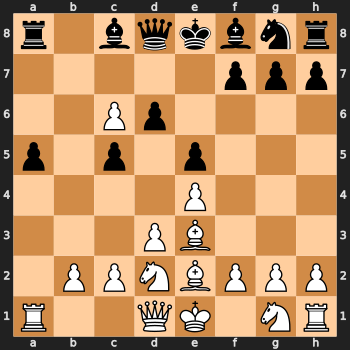

KeyboardInterrupt: 

In [46]:
import chess
import chess.svg
import time
from IPython.display import SVG, display, clear_output

board = chess.Board()

for move in test_game_moves:
    clear_output(wait=True)
    board.push_san(move)
    display(SVG(chess.svg.board(board, size=350)))
    time.sleep(1)


In [ ]:
board.piece_at(chess.A4).piece_type

6

In [4]:
def get_square_position(square):
    letter_ascii = ord(square[0])
    digit = int(square[1])

    return (letter_ascii - ord('a')) + (8 * (digit - 1))

def encode_position(move):
    from_position = get_square_position(move[0:2])
    to_position = get_square_position(move[2:4])

    return from_position * 64 + to_position

def decode_position(encoded):
    to_position = encoded % 64
    from_position = encoded // 64

    return (from_position, to_position)

def infer_move(board, original):
    move = board.parse_san(original)

    from_square = chess.square_name(move.from_square)
    to_square = chess.square_name(move.to_square)

    return encode_position(from_square + to_square)

The idea is that we train the neural net to simply predict the next move. For that, purpose we will feed board positions, and use the actual move done by the human as label

As an idea for future iterations, we can probably just use winners' moves as training data (still a player can play awfuly during the whole game, but somehow win in the end)

In [ ]:
print(chess.PAWN)
print(chess.KNIGHT)
print(chess.BISHOP)
print(chess.ROOK)
print(chess.QUEEN)
print(chess.KING)

1
2
3
4
5
6


In [5]:
UNIQUE_PIECES = 6

def encode_piece(piece_type, is_white):
    if is_white:
        return piece_type

    return piece_type + UNIQUE_PIECES

def board_to_vector(board): 
    vector = np.zeros(64, dtype=np.float32)
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        if piece:
            vector[square] = encode_piece(piece_type=piece.piece_type, is_white=piece.color)
    return vector
    

# form input (1-d 64 elements array) & output (0-4096 label)
# each move is basically a separate training example
def preprocess_game(moves):
    board = chess.Board()
    split_moves = moves.split(' ')

    X_list = []
    y_list = []

    for move in split_moves:
        # fill input matrix (flattened)
        flattened_X = board_to_vector(board)
        
        # fill output (encoded)
        label = infer_move(board, move)

        board.push_san(move)

        X_list.append(flattened_X)
        y_list.append(label)

    return np.array(X_list), np.array(y_list)

In [6]:
import torch
from torch import nn

In [7]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 2048),
            nn.ReLU(),
            nn.Linear(2048, 4096),
        )
    
    def forward(self, x):
        return self.layers(x)

model = NeuralNetwork().to(device)

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [9]:
from torch.utils.data import Dataset, DataLoader

class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    total_loss = 0

    for batch_idx, (X, y) in enumerate(dataloader):
        size = len(dataloader.dataset)
        X, y = X.to(device), y.to(device)

        prediction = model(X)
        loss = loss_fn(prediction, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch_idx % 100 == 0:
            loss, current = loss.item(), (batch_idx + 1) * len(X)
            total_loss += loss
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    return total_loss / len(dataloader)

In [69]:
total_X = []
total_y = []

for batch, raw_moves in enumerate(data_df['moves']):
    (X, y) = preprocess_game(raw_moves)
    total_X.append(X)
    total_y.append(y)

combined_X = np.concatenate(total_X, axis=0)
combined_y = np.concatenate(total_y, axis=0)

dataset = ChessDataset(combined_X, combined_y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

epochs = 3

for t in range(epochs):
    avg_loss = train(dataloader, model, loss_fn, optimizer)
    print(f"Epoch {t+1}, Average loss: {avg_loss}\n-------------------------------")

print("Done!")

loss: 4.943962  [   32/1212827]
loss: 5.512435  [ 3232/1212827]
loss: 5.818685  [ 6432/1212827]
loss: 5.548163  [ 9632/1212827]
loss: 5.915920  [12832/1212827]
loss: 5.448283  [16032/1212827]
loss: 6.434027  [19232/1212827]
loss: 5.482121  [22432/1212827]
loss: 5.429405  [25632/1212827]
loss: 5.304468  [28832/1212827]
loss: 6.478105  [32032/1212827]
loss: 6.067606  [35232/1212827]
loss: 4.893525  [38432/1212827]
loss: 5.851855  [41632/1212827]
loss: 5.769475  [44832/1212827]
loss: 5.306385  [48032/1212827]
loss: 5.468846  [51232/1212827]
loss: 5.353951  [54432/1212827]
loss: 6.408345  [57632/1212827]
loss: 5.896163  [60832/1212827]
loss: 5.489731  [64032/1212827]
loss: 5.336702  [67232/1212827]
loss: 5.071945  [70432/1212827]
loss: 4.700235  [73632/1212827]
loss: 6.241795  [76832/1212827]
loss: 5.372441  [80032/1212827]
loss: 6.059703  [83232/1212827]
loss: 6.451248  [86432/1212827]
loss: 6.089051  [89632/1212827]
loss: 5.879609  [92832/1212827]
loss: 5.381149  [96032/1212827]
loss: 5.

In [70]:
torch.save(model.state_dict(), 'model/initial.pth')

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load('model/initial.pth', weights_only=False))
model.eval()
model.to(device)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=2048, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2048, out_features=4096, bias=True)
  )
)

In [71]:
model.state_dict()

OrderedDict([('layers.0.weight',
              tensor([[ 0.4944, -0.0710,  0.0442,  ..., -0.2567, -0.0654, -0.0971],
                      [-0.1451, -0.4773, -0.2303,  ..., -0.5957,  0.0490, -0.8004],
                      [-0.4477, -0.8003, -0.0794,  ..., -0.1060, -0.1399, -0.2125],
                      ...,
                      [-0.2567, -0.3875, -0.2906,  ..., -0.6466, -0.3091, -0.4060],
                      [-0.0817, -0.5423, -0.3690,  ..., -0.0812, -1.3002,  0.2631],
                      [ 0.0895,  0.1435,  0.1455,  ..., -0.0821, -0.1128, -0.1455]],
                     device='mps:0')),
             ('layers.0.bias',
              tensor([ 0.5046,  0.3587,  0.1818,  0.7627,  1.5253,  0.5022,  0.5327,  0.3823,
                       0.1429,  0.2507, -0.1260, -0.2211,  0.7721,  0.9167,  1.1320,  0.5447,
                      -0.1334,  0.1027,  0.5308, -0.3899,  0.7618,  0.6211,  1.1518,  0.3172,
                       0.8197,  0.3984,  1.2935, -0.2659,  0.4063,  0.1931,  1.3777

Let's try to play a game

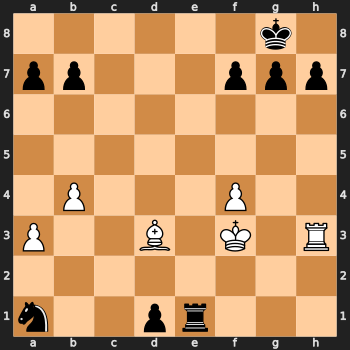

KeyboardInterrupt: Interrupted by user

In [74]:
import sys
import chess
import chess.svg
import time
from IPython.display import SVG, display, clear_output

board = chess.Board()

clear_output(wait=True)
display(SVG(chess.svg.board(board, size=350)))

while not board.is_game_over():
    clear_output(wait=True)

    vector = board_to_vector(board)
    model_prediction = model(torch.from_numpy(vector).to(device)).cpu().detach().numpy()
    for index, move in enumerate(model_prediction):
        (move_from, move_to) = decode_position(index)
        if not board.is_legal(chess.Move(move_from, move_to)):
            model_prediction[index] = -sys.maxsize - 1

    model_move = np.argmax(model_prediction)

    (model_from, model_to) = decode_position(model_move)
    board.push(chess.Move(model_from, model_to))

    display(SVG(chess.svg.board(board, size=350)))

    time.sleep(1)

    player_from = input("Enter square from: ")
    player_to = input("Enter square to: ")

    board.push(chess.Move(int(player_from), int(player_to)))

clear_output(wait=True)
display(SVG(chess.svg.board(board, size=350)))

Ok, it sucks a lot. Let's get more training examples from other datasets to see if we can fix it

In [11]:
big_data_df = pd.read_csv('./data/chess_games_big.csv')

In [77]:
len(big_data_df['AN'])

6256184

In [78]:
big_data_df['AN'].head()

0    1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1    1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2    1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3    1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4    1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
Name: AN, dtype: object

We can see that moves are in a little different format, let's write a separate "adapter" to make it compatible with our existing `preprocess_game` method

In [15]:
import re

def parse_new_format(game_history):
    no_numbers = re.sub(r'\d+\.', '', game_history)
    
    moves = [move.strip() for move in no_numbers.split() if move.strip()]
    moves.pop() # remove winner / loser

    return ' '.join(moves)

parse_new_format(big_data_df['AN'][5])

'e4 e5 Nc3 d6 Nf3 h6 Bc4 c6 b3 Qf6 Bb2 b5 Be2 Be6 d4 Be7 dxe5 dxe5 Qd2 Nd7 O-O-O Rd8 Bd3 a5 Ne2 b4 h4 g5 hxg5 hxg5 Rxh8 Qxh8 Nxg5 Bf8 Nxe6 fxe6 Qg5 Bh6 Qxh6 Qxh6+ Kb1 Ngf6 g3 Ng4 f4 Ne3 Rd2 Nc5 Bxe5 Nxd3 Rxd3 Rxd3 cxd3 Qh1+ Nc1 Qg2 Bd4 Qc2+ Ka1 Nd1 Ne2 Qxe2 g4 Qxd3 Be5 Qxe4 g5 Ne3 g6 Qxg6 a4 Qg1+ Kb2 Qf2+ Ka1 Qe1+ Kb2 Qd2+ Ka1 Qc1+ Ka2 Qc2+ Bb2 Nd1 f5 Qxb2#'

In [21]:
import sys
import chess
import chess.svg
import time
from IPython.display import SVG, display, clear_output

total_X = []
total_y = []

for raw_moves in data_df['moves']:
    (X, y) = preprocess_game(raw_moves)
    total_X.append(X)
    total_y.append(y)

for raw_moves in big_data_df['AN'][0:1000000]: # lets start by processing 100_000 games
    parsed = parse_new_format(raw_moves)
    try:
        (X, y) = preprocess_game(parsed)
        total_X.append(X)
        total_y.append(y)
    except Exception as ex: # some moves are still not compatible
        continue 

combined_X = np.concatenate(total_X, axis=0)
combined_y = np.concatenate(total_y, axis=0)

dataset = ChessDataset(combined_X, combined_y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

print(len(combined_X), len(combined_y))

60357633 60357633


In [25]:
from torch.utils.data import Subset

epochs = 3

subset_indices = list(range(10_000_000))
subset = Subset(dataset, subset_indices)

subset_dataloader = DataLoader(subset, batch_size=32, shuffle=True)

for t in range(epochs):
    avg_loss = train(subset_dataloader, model, loss_fn, optimizer)
    print(f"Epoch {t+1}, Average loss: {avg_loss}\n-------------------------------")

print("Done!")

loss: 4.473262  [   32/10000000]
loss: 4.448082  [ 3232/10000000]
loss: 4.468487  [ 6432/10000000]
loss: 4.151071  [ 9632/10000000]
loss: 4.557467  [12832/10000000]
loss: 4.276440  [16032/10000000]
loss: 5.275796  [19232/10000000]
loss: 4.255869  [22432/10000000]
loss: 4.407818  [25632/10000000]
loss: 3.953843  [28832/10000000]
loss: 4.647760  [32032/10000000]
loss: 4.090723  [35232/10000000]
loss: 3.993726  [38432/10000000]
loss: 4.855758  [41632/10000000]
loss: 4.121577  [44832/10000000]
loss: 4.896294  [48032/10000000]
loss: 4.463340  [51232/10000000]
loss: 4.455217  [54432/10000000]
loss: 4.945457  [57632/10000000]
loss: 4.927066  [60832/10000000]
loss: 4.124409  [64032/10000000]
loss: 3.962819  [67232/10000000]
loss: 4.324494  [70432/10000000]
loss: 4.507856  [73632/10000000]
loss: 4.260054  [76832/10000000]
loss: 4.722737  [80032/10000000]
loss: 5.158544  [83232/10000000]
loss: 4.105959  [86432/10000000]
loss: 4.289115  [89632/10000000]
loss: 4.429763  [92832/10000000]
loss: 4.24

In [26]:
torch.save(model.state_dict(), 'model/initial.pth')

In [ ]:
import sys
import chess
import chess.svg
import time
from IPython.display import SVG, display, clear_output

board = chess.Board()

clear_output(wait=True)
display(SVG(chess.svg.board(board, size=350)))

while not board.is_game_over():
    clear_output(wait=True)

    vector = board_to_vector(board)
    model_prediction = model(torch.from_numpy(vector).to(device)).cpu().detach().numpy()
    for index, move in enumerate(model_prediction):
        (move_from, move_to) = decode_position(index)
        if not board.is_legal(chess.Move(move_from, move_to)):
            model_prediction[index] = -sys.maxsize - 1

    model_move = np.argmax(model_prediction)

    (model_from, model_to) = decode_position(model_move)
    board.push(chess.Move(model_from, model_to))

    display(SVG(chess.svg.board(board, size=350)))

    time.sleep(1)

    player_from = input("Enter square from: ")
    player_to = input("Enter square to: ")

    board.push(chess.Move(int(player_from), int(player_to)))

clear_output(wait=True)
display(SVG(chess.svg.board(board, size=350)))